# Técnicas Clássicas de Reconhecimento de Padrões (2020/01)
## Artigo 02 - SHAP Sentiment Analysis

**Aluno: Ramon Gomes Durães de Oliveira (2019720188)**

## Bibliotecas

In [1]:
import itertools
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
import shap
shap.initjs()

Funções utilitárias para explorar o modelo de tokenização TF-IDF:

In [3]:
# Decodifica uma review
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# Obtém as palavras com mais peso em uma review
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

# Retorna as n features (palavras) que, em média, são as mais importantes nas reviews desejadas
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# Retorna uma lista de DataFrames na qual cada DF tem as top N features (palavras) e seu 
# valor TFIDF médio, calculado em todos os documentos da mesma classe.
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

# Função utilitária para plotar resulados
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function top_feats_by_class(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

## Carregando e pré-processando os dados

Os dados que serão utilizados abaixo são provenientes da competição do Kaggle intitulada "Brazilian E-Commerce Public Dataset by Olist", disponível em https://www.kaggle.com/olistbr/brazilian-ecommerce. 

Os dados são avaliações de produtos na loja Olist feitas por consumidores brasileiros. Os dados serão carregados para visualização abaixo:

In [4]:
data = pd.read_csv('./data/olist_order_reviews_dataset.csv')
print(data.shape)
data.head()

(100000, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


Nota-se que as colunas mais relevantes para a análise são `review_score`, onde está a nota da avaliação de 1 a 5 estrelas, e `review_comment_message`, onde está o texto da avaliação em si. 

Como estamos interessados em classificar novas avaliações, serão removidas as avaliações sem texto (NaN):

In [5]:
data.dropna(axis='rows', subset=['review_comment_message'], inplace=True)
print(data.shape)

(41753, 7)


Nota-se que a base de dados passa de 100.000 para 41753 observações. Agora serão checados valores faltantes na segunda coluna de interesse: `review_score`: 

In [6]:
sum(data['review_score'].isna())

0

Não há valores faltantes na coluna `review_score`. 

In [7]:
data['review_score'].head()

3     5
4     5
9     4
12    4
15    5
Name: review_score, dtype: int64

Visualizando a distribuição de notas 

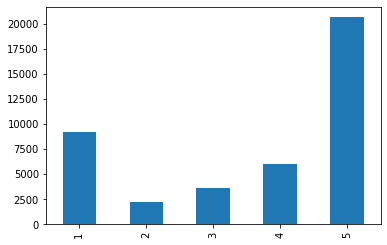

In [8]:
data['review_score'].value_counts(sort=False).plot(kind='bar')

Para este trabalho, estamos interessados apenas em distinguir avaliações positivas de negativas, por isso elas serão agregadas de forma que as notas de 1 a 3 sejam consideradas negativas (-1) e as notas 4 e 5 positivas (1).

In [9]:
data['grouped_review'] = data['review_score'].where(data['review_score']>3, -1)
data['grouped_review'] = data['grouped_review'].where(data['grouped_review']<=3, 1)
data[['review_comment_message', 'review_score', 'grouped_review']].head(15)

,review_comment_message,review_score,grouped_review
3,Recebi bem antes do prazo estipulado.,5,1
4,Parabéns lojas lannister adorei comprar pela I...,5,1
9,aparelho eficiente. no site a marca do aparelh...,4,1
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,1
15,"Vendedor confiável, produto ok e entrega antes...",5,1
16,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2,-1
19,Péssimo,1,-1
22,Loja nota 10,5,1
24,obrigado pela atençao amim dispensada,5,1
27,A compra foi realizada facilmente.\r\nA entreg...,5,1


### Limpeza do texto

Dados textuais crus contém uma série de caracteres indesejáveis, além de letras maiúsculas e minúsculas que deveriam ser tratadas como a mesma palavra. A função abaixo removerá:
- pontuação
- letras maiúsculas
- colchetes
- padrões especiais como \r e \n
- aspas

In [10]:
from unicodedata import normalize

In [11]:
def text_clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\r\n|\r|\n', '', text)
    text = re.sub('[‘’“”…]', '', text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    return text

clean = lambda x: text_clean(x)

Exibindo algumas avaliações pós-processamento:

In [12]:
data['clean_review_message'] = pd.DataFrame(data.review_comment_message.apply(clean))
data['clean_review_message'].head(10)

3                  recebi bem antes do prazo estipulado
4     parabens lojas lannister adorei comprar pela i...
9     aparelho eficiente no site a marca do aparelho...
12               mas um pouco travandopelo valor ta boa
15    vendedor confiavel produto ok e entrega antes ...
16    gostaria de saber o que houve sempre recebi e ...
19                                              pessimo
22                                           loja nota 
24                obrigado pela atencao amim dispensada
27    a compra foi realizada facilmentea entrega foi...
Name: clean_review_message, dtype: object

### Separando conjuntos de treinamento e teste

Serão utilizados 20% dos dados fornecidos como dados de teste.

In [13]:
from sklearn.model_selection import train_test_split

X = data['clean_review_message']
Y = data['grouped_review']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.2, random_state=1)

print("Tamanho do conjunto de treinamento: {}\nTamanho do conjunto de teste: {}".format(len(Ytrain), len(Ytest)))

Tamanho do conjunto de treinamento: 33402
Tamanho do conjunto de teste: 8351


## Modelo 1: TF-IDF + Regressão Logística

### Tokenização: TF-IDF:

Para este modelo, a forma escolhida de representação do texto foi a transformação (vetorização) pelo método TF-IDF (Term Frequency - Inverse Document Frequency). 

O objetivo deste método é aumentar o peso dado a uma palavra (feature) quanto maior o número de ocorrências dela em uma review, mas atenuar este peso de acordo com o número total de ocorrências dela em todo o conjutno de dados. Com isso, é possível remover a importância dada a palavras extremamente comuns como artigos ("o", "a") e outras palavras muito comuns que não ajudariam a discernir uma review positiva de uma review negativa ("é", "eu", ...).

Olhando mais a fundo para o significado de cada termo:
- TF (Term Frequency): frequência de uma palavra na review em questão. Sendo $t$ uma palavra e $d$ uma review, a função  é definida por: 

$tf(t,d)=\frac{n_{t,d}}{\sum_k n_{t,d}}$

- IDF (Inverse Document Frequency): número total de reviews dividido pelo número de reviews que contém o termo em questão. Sendo $N$ o número total de reviews e $D$ o conjunto contendo todas as reviews do banco de dados:

$idf(t,D)=log(\frac{N}{|\{d \in D \mid t \in d\}|})$

- TF-IDF (Inverse Document Frequency): a combinação dessas funções: 

$tfidf(t,D)=tf(t,D) * idf(t, D)$

Ajustando este modelo aos dados e exibindo parte do dicionário gerado:

In [14]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression(solver = "liblinear")
linear_model = Pipeline([('vectorizer',vectorizer),('classifier',classifier)])
linear_model.fit(Xtrain, Ytrain);
tfidf = linear_model.steps[0][1]
dict(itertools.islice(tfidf.vocabulary_.items(), 10))

{'produto': 12770,
 'nao': 10502,
 'foi': 7458,
 'entregue': 6073,
 'gostaria': 7966,
 'de': 4350,
 'saber': 14430,
 'nova': 10757,
 'previsao': 12591,
 'entrega': 5979}

Para visualizar um exemplo do resultado da tokenização, será utilizada a frase:

In [15]:
print(Xtrain.iloc[0])

o produto nao foi entregue gostaria de saber a nova previsao de entrega o processo de entrega esta na situacao de nota fiscal emitida desde  sem ter nunca ido para transportadora


Após a tokenização, este é o peso dado às 10 palavras mais relevantes desta frase:

In [16]:
transformed_Xtrain = tfidf.transform(Xtrain)
all_features = tfidf.get_feature_names() 
row1 = np.squeeze(transformed_Xtrain[0].toarray())
top_tfidf_feats(row = row1, features=all_features, top_n=10)

,feature,tfidf
0,de,0.337228
1,ido,0.325141
2,nova,0.270770
3,emitida,0.261907
4,situacao,0.254893
5,transportadora,0.238061
6,processo,0.237636
7,desde,0.226878
8,previsao,0.225671
9,entrega,0.195505


Exibindo as palavras mais relevantes por classe (lembrando que -1 representa avaliações negativas e 1 representa avaliações positivas).

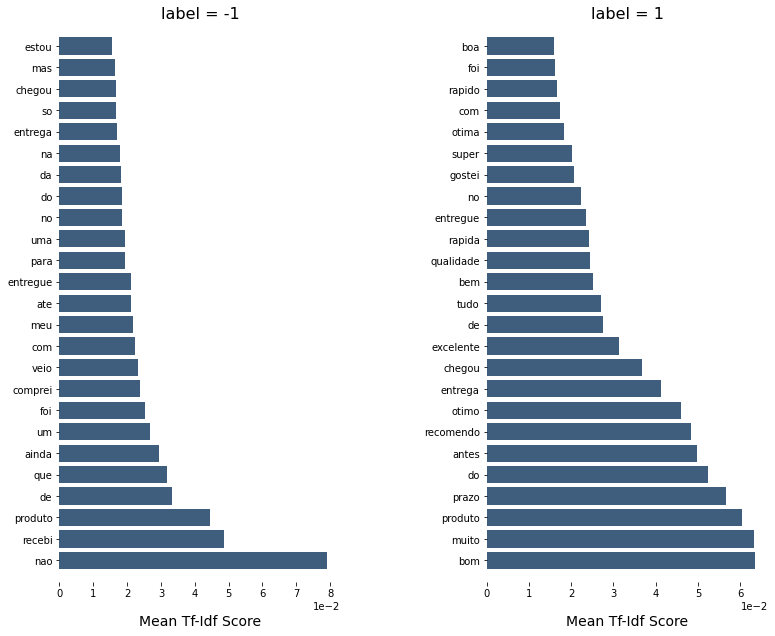

In [17]:
dfs = top_feats_by_class(transformed_Xtrain, Ytrain, tfidf.get_feature_names())
plot_tfidf_classfeats_h(dfs)

### Predição do Modelo: Regressão Logística

Para classificar os dados, novamente será utilizado um simples modelo de regressão logística. Abaixo é mostrada a matriz de confusão obtida:

In [18]:
predictions = linear_model.predict(Xtest)
confusion_matrix(predictions, Ytest)

array([[2555,  442],
       [ 460, 4894]], dtype=int64)

In [19]:
scores = cross_val_score(linear_model, Xtrain, Ytrain, cv=5)
cv_accuracy = 100 * np.mean(scores)
print("Acurácia obtida por validações cruzada com 5 partições: {}%".format(round(cv_accuracy, 2)))

Acurácia obtida por validações cruzada com 5 partições: 89.29%


Testando com novas frases:

In [20]:
linear_model.predict(['estou feliz com a compra'])

array([1], dtype=int64)

In [21]:
linear_model.predict(['fiquei chateado'])

array([-1], dtype=int64)

In [22]:
linear_model.predict(['estou triste com a compra'])

array([-1], dtype=int64)

In [23]:
linear_model.predict(['me agradou muito'])

array([1], dtype=int64)

In [24]:
linear_model.predict(['demorou a chegar'])

array([-1], dtype=int64)

A pipeline de processamento de dados, juntamente ao modelo de tokenização TF-IDF e à classificação por regressão logística simples se mostraram eficientes na solução do problema, obtendo 89% de acurácia. Como esperado, o modelo classifica melhor as avaliações positivas devido ao desbalanceamento das classes. 

O modelo foi capaz de classificar corretamente as frases de teste fornecidas.

###  Linear SHAP

In [25]:
import shap

In [26]:
corpus = data['clean_review_message']
y = data['grouped_review']

In [27]:
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

In [28]:
lmodel = LogisticRegression(penalty="l1", C=0.1)
lmodel.fit(X_train, y_train)

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
explainer = shap.LinearExplainer(lmodel, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


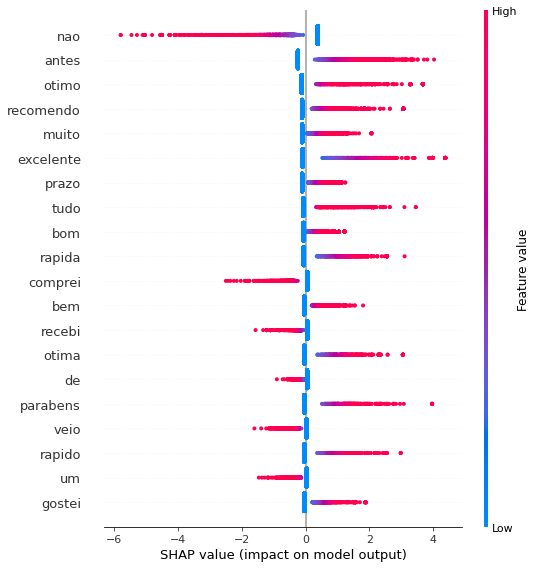

In [30]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

In [32]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

# Word2Vec + t-SNE

In [33]:
# importing all necessary modules 
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

## Building a corpus

In [35]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data.iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data['clean_review_message'])
corpus[0:2]

[['recebi', 'bem', 'antes', 'do', 'prazo', 'estipulado'],
 ['parabens',
  'lojas',
  'lannister',
  'adorei',
  'comprar',
  'pela',
  'internet',
  'seguro',
  'e',
  'pratico',
  'parabens',
  'a',
  'todos',
  'feliz',
  'pascoa']]

## Word2Vec

In [36]:
from gensim.models import word2vec

In [37]:
wvmodel = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [38]:
wvmodel.wv['adorei']

array([-0.11163469, -0.86656386, -0.00980954,  0.52687615,  0.2817998 ,
        0.52826   ,  0.14316764,  0.5322925 , -0.36956206, -0.27984014,
        0.5805807 ,  0.15974101,  0.26798984,  0.18243165,  0.5979676 ,
        0.54647326, -0.45824352, -0.16681498, -0.7869494 , -0.10787231,
        0.52610505,  0.42581195,  0.1475161 ,  0.44923002,  0.64689976,
        0.33963895, -0.25659654, -0.07625286,  0.25040737,  0.25193474,
       -0.0849639 , -0.0278755 , -0.26477003,  0.06582355, -0.11289389,
       -0.63478386,  0.3220616 ,  0.0658585 ,  0.41250226, -0.6449634 ,
        0.07399147,  0.74181986, -0.4185112 , -0.47050884, -0.47989118,
       -0.25979948, -0.06516114, -0.3606537 , -0.2420769 ,  0.2514188 ,
        0.19795097, -0.31264707,  0.7961927 ,  0.28648204,  0.04732282,
        0.02791687,  0.9383013 ,  0.11027247, -0.01218895,  0.24867247,
       -0.06804917, -0.14849523, -0.2751606 ,  1.2427405 , -0.26082575,
        0.09778585, -0.20090175, -0.3978137 ,  0.13888016, -0.25

## t-SNE plot

In [39]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

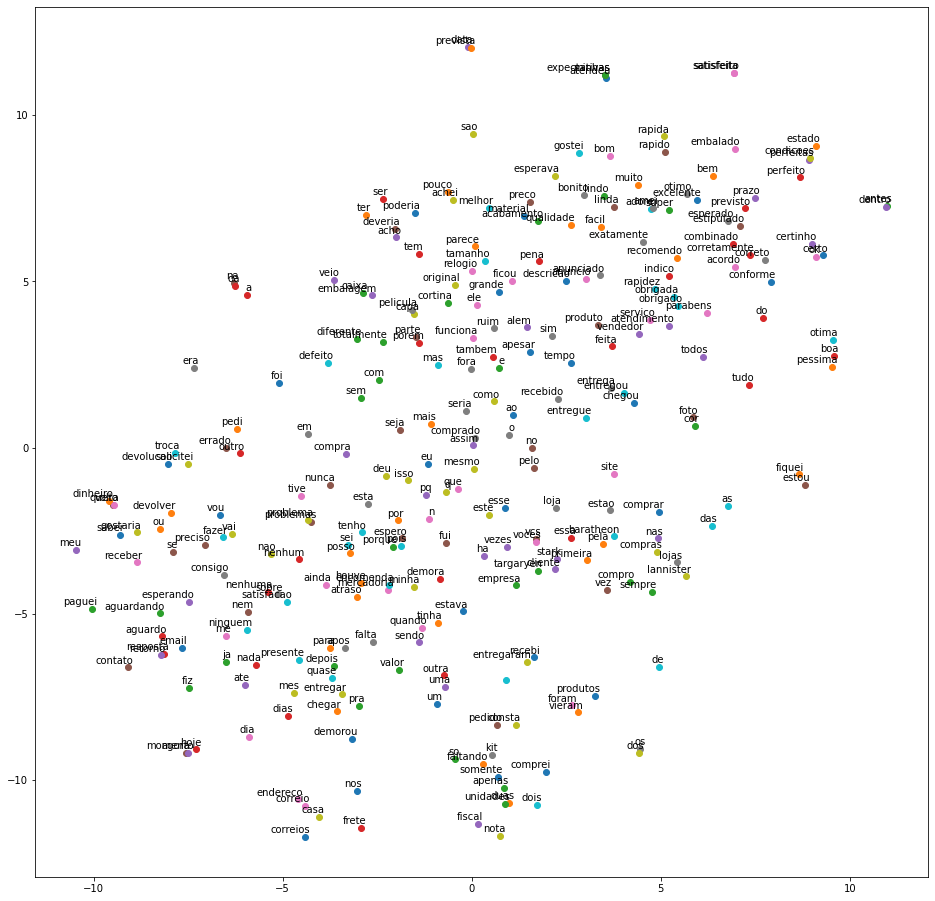

In [40]:
tsne_plot(wvmodel)

## Based on SHAP values

In [41]:
shap_df = pd.DataFrame(shap_values, columns=vectorizer.get_feature_names())
shap_df.head()

,abaixo,aberta,aberto,abraco,abri,abrir,absurdo,acabado,acabamento,acabei,...,volto,voltou,volume,vontade,vou,whey,xl,zenfone,zero,ziper
0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [42]:
threshold = 0.001
median_shaps = shap_df.median()[shap_df.median().abs() > threshold]
median_shaps

acordo         -0.002938
adorei         -0.027194
agora           0.002109
aguardando      0.015195
aguardo         0.004703
amei           -0.017309
antes          -0.238504
apenas          0.007359
ate             0.020456
atendeu        -0.002598
atendimento    -0.003203
atraso          0.002662
baixa           0.001122
bem            -0.045039
boa            -0.015713
bom            -0.062008
bonito         -0.001944
certinho       -0.006610
certo          -0.006674
chegou         -0.007153
com             0.004868
comprar        -0.008701
comprei         0.048850
condicoes      -0.001629
conforme       -0.017960
contato         0.004713
corretamente   -0.002087
correto        -0.004529
da              0.009040
de              0.047074
                  ...   
por             0.001050
porem           0.007044
prazo          -0.108377
problemas      -0.001298
qualidade      -0.030860
quando          0.003107
que             0.012654
quebrado        0.001531
quero           0.008716


In [43]:
order = median_shaps.map(lambda x : x).abs().sort_values(ascending = False)
ordered_median_shaps = median_shaps[order.index]
ordered_median_shaps

nao             0.381002
antes          -0.238504
otimo          -0.118667
recomendo      -0.110969
muito          -0.109846
prazo          -0.108377
excelente      -0.092958
tudo           -0.070150
bom            -0.062008
rapida         -0.054227
comprei         0.048850
recebi          0.047651
de              0.047074
bem            -0.045039
otima          -0.040367
parabens       -0.035804
veio            0.035716
um              0.035592
rapido         -0.035589
super          -0.032521
gostei         -0.032417
qualidade      -0.030860
perfeito       -0.029721
adorei         -0.027194
do              0.025045
dentro         -0.021658
uma             0.020739
ate             0.020456
satisfeita     -0.018233
conforme       -0.017960
                  ...   
atraso          0.002662
atendeu        -0.002598
nada            0.002576
linda          -0.002411
embalado       -0.002353
obrigada       -0.002297
era             0.002241
ou              0.002146
agora           0.002109


In [44]:
median_shaps_colors = median_shaps.map(lambda x : 'red' if x>0 else 'blue')

In [45]:
def tsne_plot(model, median_shaps_colors):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], c = [median_shaps_colors[labels[i]] if labels[i] in median_shaps_colors else 'grey'])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

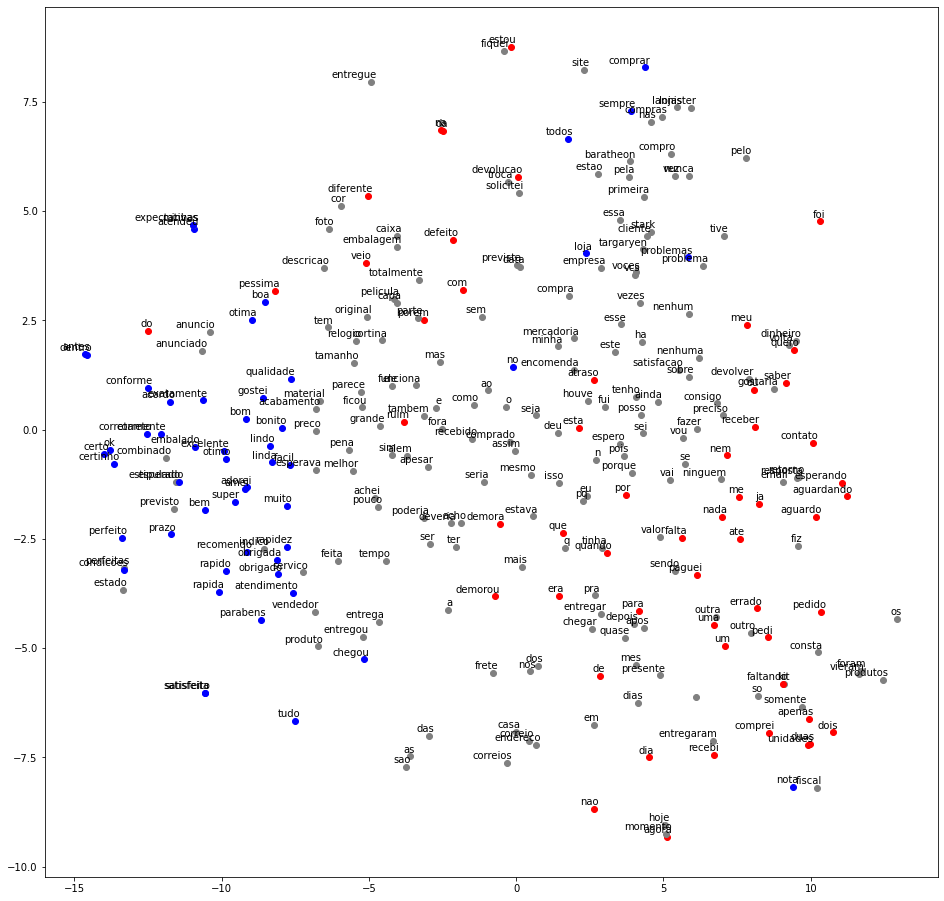

In [46]:
tsne_plot(wvmodel, median_shaps_colors)

### Alterando o Threshold

In [47]:
threshold = 0.05
median_shaps = shap_df.median()[shap_df.median().abs() > threshold]
median_shaps_colors = median_shaps.map(lambda x : 'red' if x>0 else 'blue')
order = median_shaps.map(lambda x : x).abs().sort_values(ascending = False)
ordered_median_shaps = median_shaps[order.index]
ordered_median_shaps

nao          0.381002
antes       -0.238504
otimo       -0.118667
recomendo   -0.110969
muito       -0.109846
prazo       -0.108377
excelente   -0.092958
tudo        -0.070150
bom         -0.062008
rapida      -0.054227
dtype: float64

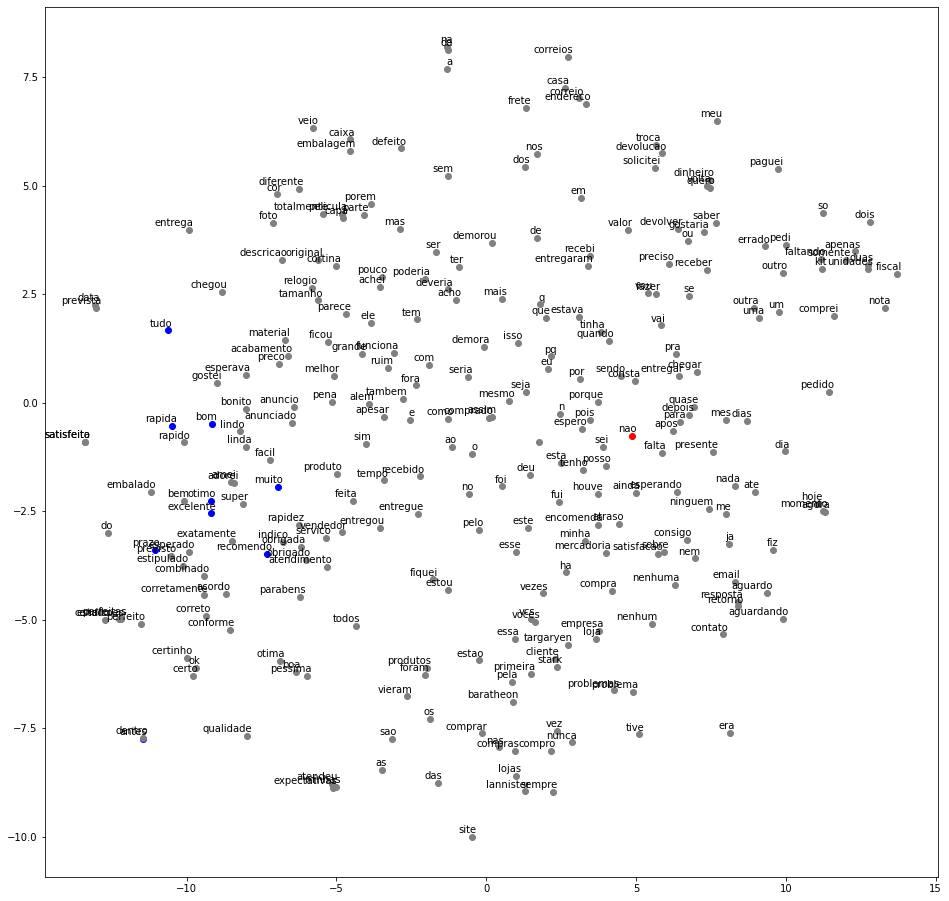

In [48]:
tsne_plot(wvmodel, median_shaps_colors)

# IMDB Data

In [61]:
corpus,y = shap.datasets.imdb()
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

In [50]:
model = LogisticRegression(penalty="l1", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() 

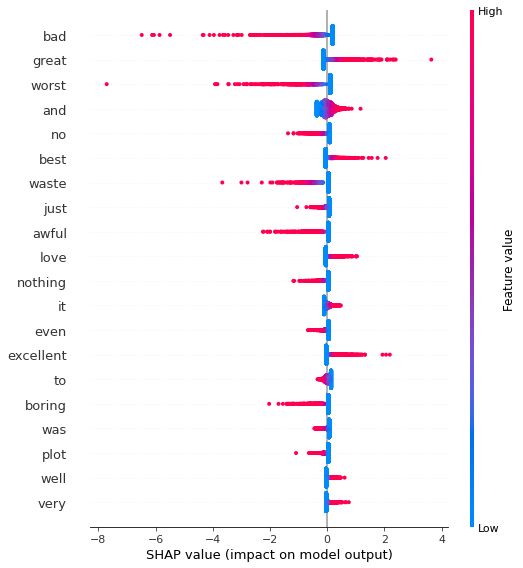

In [52]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

## Word2Vec

In [64]:
imdb_corpus = corpus
imdb_corpus[3]

'Sorry everyone,,, I know this is supposed to be an "art" film,, but wow, they should have handed out guns at the screening so people could blow their brains out and not watch. Although the scene design and photographic direction was excellent, this story is too painful to watch. The absence of a sound track was brutal. The loooonnnnng shots were too long. How long can you watch two people just sitting there and talking? Especially when the dialogue is two people complaining. I really had a hard time just getting through this film. The performances were excellent, but how much of that dark, sombre, uninspired, stuff can you take? The only thing i liked was Maureen Stapleton and her red dress and dancing scene. Otherwise this was a ripoff of Bergman. And i\'m no fan f his either. I think anyone who says they enjoyed 1 1/2 hours of this is,, well, lying.\n'

In [66]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)
            
    return corpus

In [67]:
corpus = build_corpus(imdb_corpus)
corpus[0:2]

[['Story',
  'of',
  'a',
  'man',
  'who',
  'has',
  'unnatural',
  'feelings',
  'for',
  'a',
  'pig.',
  'Starts',
  'out',
  'with',
  'a',
  'opening',
  'scene',
  'that',
  'is',
  'a',
  'terrific',
  'example',
  'of',
  'absurd',
  'comedy.',
  'A',
  'formal',
  'orchestra',
  'audience',
  'is',
  'turned',
  'into',
  'an',
  'insane,',
  'violent',
  'mob',
  'by',
  'the',
  'crazy',
  'chantings',
  'of',
  "it's",
  'singers.',
  'Unfortunately',
  'it',
  'stays',
  'absurd',
  'the',
  'WHOLE',
  'time',
  'with',
  'no',
  'general',
  'narrative',
  'eventually',
  'making',
  'it',
  'just',
  'too',
  'off',
  'putting.',
  'Even',
  'those',
  'from',
  'the',
  'era',
  'should',
  'be',
  'turned',
  'off.',
  'The',
  'cryptic',
  'dialogue',
  'would',
  'make',
  'Shakespeare',
  'seem',
  'easy',
  'to',
  'a',
  'third',
  'grader.',
  'On',
  'a',
  'technical',
  'level',
  "it's",
  'better',
  'than',
  'you',
  'might',
  'think',
  'with',
  'some',
  'good',
  'cinematography',
  'by',
  'future',
  'great',
  'Vilmos',
  'Zsigmond.',
  'Future',
  'stars',
  'Sally',
  'Kirkland',
  'and',
  'Frederic',
  'Forrest',
  'can',
  'be',
  'seen',
  'briefly.\n'],
 ['Airport',
  "'77",
  'starts',
  'as',
  'a',
  'brand',
  'new',
  'luxury',
  '747',
  'plane',
  'is',
  'loaded',
  'up',
  'with',
  'valuable',
  'paintings',
  '&',
  'such',
  'belonging',
  'to',
  'rich',
  'businessman',
  'Philip',
  'Stevens',
  '(James',
  'Stewart)',
  'who',
  'is',
  'flying',
  'them',
  '&',
  'a',
  'bunch',
  'of',
  "VIP's",
  'to',
  'his',
  'estate',
  'in',
  'preparation',
  'of',
  'it',
  'being',
  'opened',
  'to',
  'the',
  'public',
  'as',
  'a',
  'museum,',
  'also',
  'on',
  'board',
  'is',
  'Stevens',
  'daughter',
  'Julie',
  '(Kathleen',
  'Quinlan)',
  '&',
  'her',
  'son.',
  'The',
  'luxury',
  'jetliner',
  'takes',
  'off',
  'as',
  'planned',
  'but',
  'mid-air',
  'the',
  'plane',
  'is',
  'hi-jacked',
  'by',
  'the',
  'co-pilot',
  'Chambers',
  '(Robert',
  'Foxworth)',
  '&',
  'his',
  'two',
  "accomplice's",
  'Banker',
  '(Monte',
  'Markham)',
  '&',
  'Wilson',
  '(Michael',
  'Pataki)',
  'who',
  'knock',
  'the',
  'passengers',
  '&',
  'crew',
  'out',
  'with',
  'sleeping',
  'gas,',
  'they',
  'plan',
  'to',
  'steal',
  'the',
  'valuable',
  'cargo',
  '&',
  'land',
  'on',
  'a',
  'disused',
  'plane',
  'strip',
  'on',
  'an',
  'isolated',
  'island',
  'but',
  'while',
  'making',
  'his',
  'descent',
  'Chambers',
  'almost',
  'hits',
  'an',
  'oil',
  'rig',
  'in',
  'the',
  'Ocean',
  '&',
  'loses',
  'control',
  'of',
  'the',
  'plane',
  'sending',
  'it',
  'crashing',
  'into',
  'the',
  'sea',
  'where',
  'it',
  'sinks',
  'to',
  'the',
  'bottom',
  'right',
  'bang',
  'in',
  'the',
  'middle',
  'of',
  'the',
  'Bermuda',
  'Triangle.',
  'With',
  'air',
  'in',
  'short',
  'supply,',
  'water',
  'leaking',
  'in',
  '&',
  'having',
  'flown',
  'over',
  '200',
  'miles',
  'off',
  'course',
  'the',
  'problems',
  'mount',
  'for',
  'the',
  "survivor's",
  'as',
  'they',
  'await',
  'help',
  'with',
  'time',
  'fast',
  'running',
  'out...<br',
  '/><br',
  '/>Also',
  'known',
  'under',
  'the',
  'slightly',
  'different',
  'tile',
  'Airport',
  '1977',
  'this',
  'second',
  'sequel',
  'to',
  'the',
  'smash-hit',
  'disaster',
  'thriller',
  'Airport',
  '(1970)',
  'was',
  'directed',
  'by',
  'Jerry',
  'Jameson',
  '&',
  'while',
  'once',
  'again',
  'like',
  "it's",
  'predecessors',
  'I',
  "can't",
  'say',
  'Airport',
  "'77",
  'is',
  'any',
  'sort',
  'of',
  'forgotten',
  'classic',
  'it',
  'is',
  'entertaining',
  'although',
  'not',
  'necessarily',
  'for',
  'the',
  'right',
  'reasons.',
  'Out',
  'of',
  'the',
  'three',
  'Airport',
  'films',
  'I',
  'have',
  'seen',
  'so',
  'far',
  'I',
  'actually',
  'liked',
  'this',
  'one',
  '

In [68]:
wvmodel = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

## t-SNE + SHAP plot

In [69]:
shap_df = pd.DataFrame(shap_values, columns=vectorizer.get_feature_names())
threshold = 0.001
median_shaps = shap_df.median()[shap_df.median().abs() > threshold]
order = median_shaps.map(lambda x : x).abs().sort_values(ascending = False)
ordered_median_shaps = median_shaps[order.index]
ordered_median_shaps

bad          0.187468
great       -0.135024
worst        0.103155
no           0.085755
just         0.064281
best        -0.057866
even         0.050239
love        -0.044140
waste        0.042381
awful        0.039627
nothing      0.039446
very        -0.038910
well        -0.036983
plot         0.035777
excellent   -0.035264
boring       0.033657
they         0.033255
there        0.025616
will        -0.024023
only         0.023158
any          0.022691
minutes      0.022049
poor         0.021536
was          0.021321
wonderful   -0.021100
his         -0.020919
why          0.020804
terrible     0.020427
script       0.020340
also        -0.018659
               ...   
and         -0.010862
worse        0.010197
movie        0.009928
still       -0.009202
off          0.009121
br           0.008976
amazing     -0.008970
horrible     0.008198
make         0.008146
loved       -0.007450
thing        0.007368
fun         -0.007193
then         0.006865
is          -0.006837
instead   

In [73]:
def tsne_plot(model, median_shaps_colors):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        if labels[i] in median_shaps_colors:
            plt.scatter(x[i],y[i], c = [median_shaps_colors[labels[i]]])
            plt.annotate(labels[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom',
                        fontsize=15)
    plt.show()

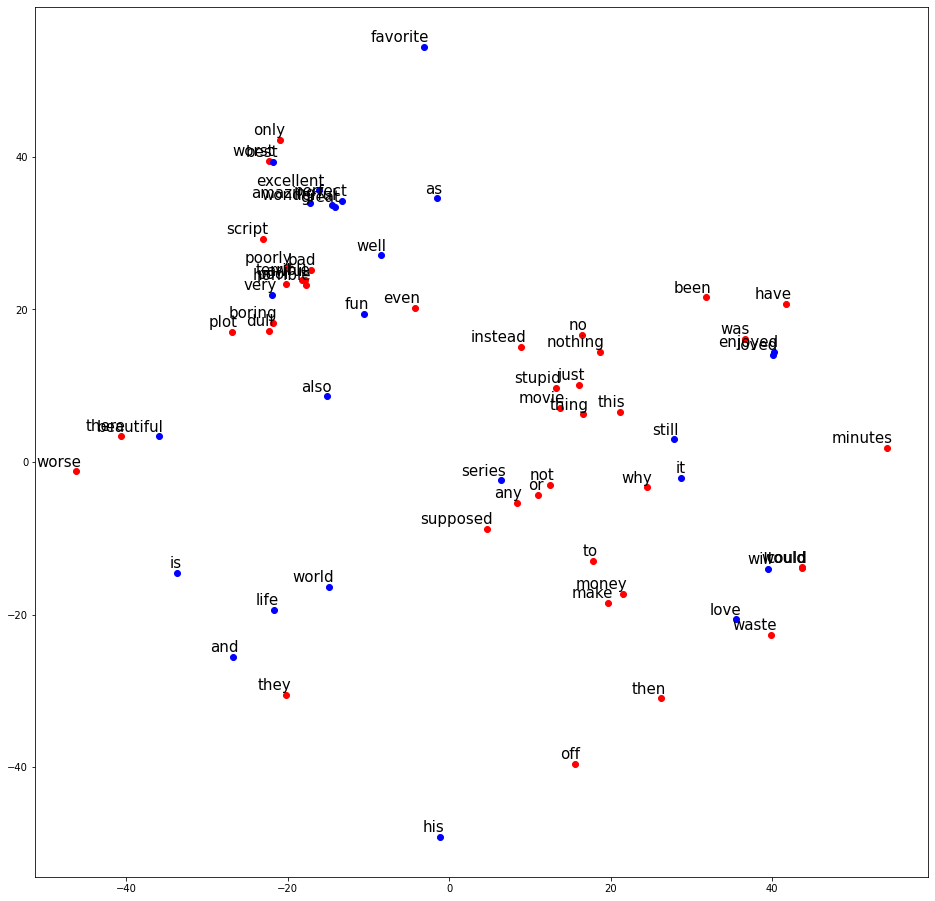

In [74]:
median_shaps_colors = median_shaps.map(lambda x : 'red' if x>0 else 'blue')
tsne_plot(wvmodel, median_shaps_colors)